# <b>Data Exploration</b>
In this notebook we use mediapipe to detect poses of the signers. The results are set of points for every frame for every video.

## 0.1 Load data

In [118]:
import pandas as pd
import os
import json
import numpy as np
import cv2
import pickle
import copy
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
working_dir = './'
data_info = pd.read_csv(os.path.join(working_dir,'video_labels.csv'),dtype={'video_id': object})
data_info.head(2)

,bbox,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,29.970030,1280,720,2.50250
1,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,07069,book,23.976024,1280,720,1.25125


## O.2 Load the video landmarks
Load from 2 files and combine it to one dictionary.

In [120]:
# Load landmarks from the pickle file
lmarks = None
def load_landmarks(filename):
    try:
        with open(os.path.join(working_dir,filename), 'rb') as file:
            lmarks = pickle.load(file)
    except FileNotFoundError:
        # If the file doesn't exist, initialize the variable
        print('Could not open landmarks.pkl')
        lmarks = {} # This value contains the landmarks points of all frames, in all the videos
    return lmarks
lmarks =  load_landmarks('landmarks_vol2.pkl') # vol2 2 has all the keys of vol_1 with empty array as values
lmarks.update(load_landmarks('landmarks.pkl')) # overrides the empty array with the relevant arrays
print(len(lmarks.keys()),'out of',len(data_info))

5401 out of 11980


## 0.3 Rearrange the landmarks
The landmarks for pose are 4 dimmensional, for hands and face they are 3 dimmensional. Let's remove the 4th dimmension (visibility) from pose.

We also want to change the dcitionary of arrays that looks like this `{'pose': [...], 'lh':[...]}` to one 3D array and keep a mask array if we want to acces face, hands or pose. This will make it easier to work with.

Lastly, if a hand is out the frame we created a zero vector, but due to a mistake it was a flattened array, we want to convert it back to 3D, will remove the `if` condition on the `shape` and the `reshape` code once the data is preprocessed through the fixed pipeline again.

In [121]:
landmarks = {key: [] for key in lmarks.keys()}

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

for key, video in lmarks.items():
    new_video = np.zeros((len(video),LANDMARKS_LENGTH,3)) # frame x landdmarks x coordinates
    for i, frame in enumerate(video):
        pose = frame['pose'][:,:3] if frame['pose'].shape == (33, 4) else frame['pose'].reshape((33, 4))[:,:3]
        lh = frame['lh'] if frame['lh'].shape == (21, 3) else frame['lh'].reshape((21, 3))
        rh = frame['rh'] if frame['rh'].shape == (21, 3) else frame['rh'].reshape((21, 3))
        face = frame['face'] if frame['face'].shape == (468, 3) else frame['face'].reshape((468, 3))
        frame_landmarks = np.vstack((pose, lh, rh, face))
        new_video[i] = frame_landmarks
    landmarks[key] = new_video
del lmarks # Release from memory


Create a mask for the landmarks array. Example how to use `landmarks['video_id'][frame,POSE,:]`

In [122]:
POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
POSE_GROUPS = {
    "eyes":                 [8, 6, 5, 4, 0, 1, 2, 3, 7],   
    "mouth":                [10, 9],                       
    "right elbow":          [13],
    "right arm":            [11, 15, 17, 19, 15, 21], 
    "right body side":      [11, 23, 25, 27, 29, 31, 27],  
    "left elbow":           [14],  
    "left arm":             [12, 16, 18, 20, 16, 22],  
    "left body side":       [12, 24, 26, 28, 30, 32, 28],  
    "shoulder":             [11, 12],                      
    "waist":                [23, 24],                      
}

# 1- Data Augmentation

In the subsequent analysis, we shift our focus from the raw images to the associated landmarks. While it's plausible to encounter slight variations in pose estimations from the Mediapipe library, we proceed with the assumption that these differences are negligible. Consequently, we treat the extracted landmarks as constant for our further analyses.

### Augmented data type
One way we augment the data is by moving the landmarks around, not linearly as a group (meaning not by shifting the whole frame to some direction), but rather as subgroup, more specifically, the hands. Different people will wave their hands in different distances from their face, so we can move the hands slighlt lower, higher, sideways in respect to the face.

What we don't want to do is to randomly add a small $\sigma_x,\sigma_y$ to each point, this cause the distortion of the picture and make it unrealistic for a human body.

Other type of augmented data are flipped pictures, we take the $x$ coordinate of the center of the face as reflection axis.

Third type of augmented data are zoomed pictures, we take the center of the frame as given in the bounding box ( given in a columnm, for each video) and push (or pull) al the points away from it.

### 1.0 Motivation
Before we jump into augmenting the data, let's understand how it looks like by plotting it.

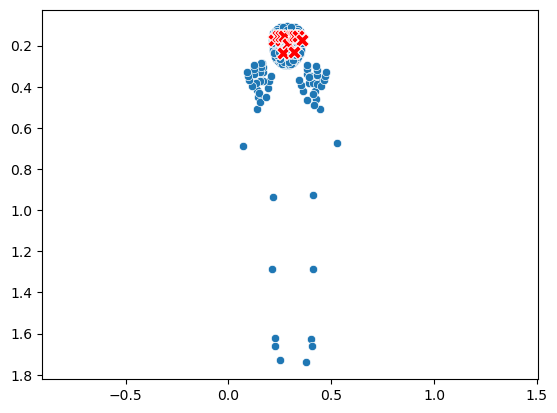

In [123]:
# A sample video to work with
key, pose = list(landmarks.items())[19]
frame = 25 # pick a good frame where all body parts are within it


def plot_landmarks(frame_landmarks, plot_parts = POSE+LH+RH+FACE, highlight=[]):
    sns.scatterplot(x=frame_landmarks[plot_parts,0], y=frame_landmarks[plot_parts,1]) # start after pose values, it shrinks the whole frame
    plt.gca().invert_yaxis()
    if len(highlight)>0:  
        sns.scatterplot(x=frame_landmarks[highlight,0], y=frame_landmarks[highlight,1], color='red', s=100, marker='X')
    plt.axis('equal')
    plt.show()

plot_landmarks(pose[frame],highlight = POSE_GROUPS['eyes']+POSE_GROUPS['mouth'])

<b>Comment: We notice that there are many points, probably many are irrelevant and we can discard them to boost the model's performance. For example, the palm bones move as a group, therefore a single point to represent the hand's location is sufficient. We should try it out.</b>

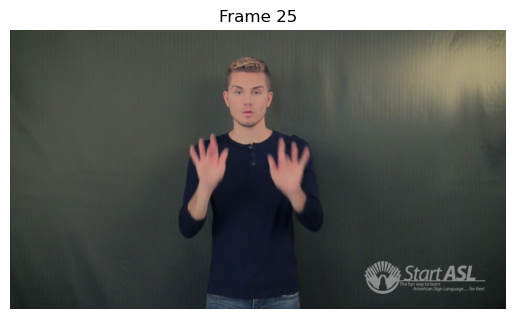

In [124]:
# Code generated by GPT 3.5 to show the same frame as the pose we worked on, for presentation purpose only
import cv2
import matplotlib.pyplot as plt

def plot_frame(video_path, frame_number):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the specified frame number is valid
    if frame_number < 0 or frame_number >= total_frames:
        print(f"Error: Invalid frame number. Must be between 0 and {total_frames - 1}.")
        cap.release()
        return

    # Set the video to the specified frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read frame.")
        cap.release()
        return

    # Display the frame using matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_number}")
    plt.axis('off')
    plt.show()

    # Release the video capture object
    cap.release()

# Example usage: Plot the 25th frame of the video 'vid.mp4'
video_path = os.path.join('videos',key+'.mp4')
frame_number = 25
plot_frame(video_path, frame_number)


## 1.1 First Augmented type
Let's first illustrate how moving the hands looks like, for one frame, before and after.

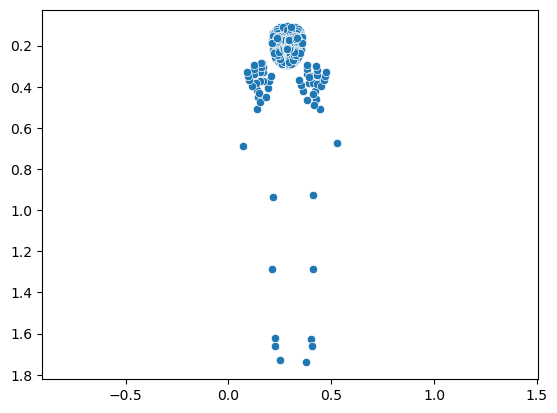

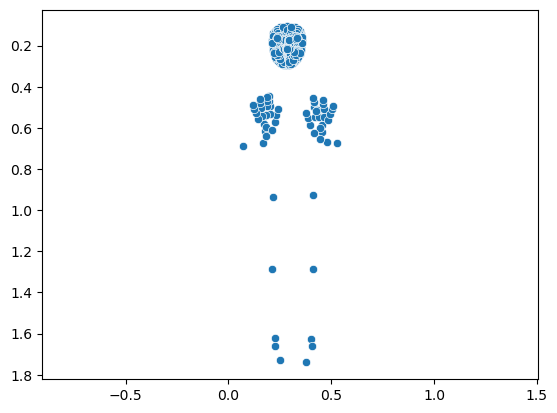

In [125]:
# Shift the hands down, for presentation purposes.
shift_rate = [7,10,1]# Percents of the total length of the x,y,z axis
                    # These will be generated randomly, in a loop, once we are done with concept testing
new_pose = copy.deepcopy(pose)

frame = new_pose[25]

interval = [frame[:,i].max()-frame[:,i].min() for i in range(3)]
shift = [shift_rate[i]*interval[i]/100 for i in range(3)]

plot_landmarks(frame)
for i in range(3): # Shift for each axis
    frame[POSE_GROUPS['right arm']+POSE_GROUPS['left arm'],i] += shift[i]
    frame[LH,i] += shift[i]
    frame[RH,i] += shift[i]
plot_landmarks(frame)


In the next cell we do the same as in the previous one, but as part of the real pipeline and not just for presentation purposes.

Instead of shifting the hands by the same distance for each frame, the change is different for each frame but with a smooth transition. For example, if in the first frame out of 11 we move 5 pixels to the right and in the last frame 5 pixels to the left, then in the fifth frame the don't change, while in 4'th frame they are 1 pixel to the right.

In [126]:
'''
Shifts the hands, with the wrists on x,y, and z axis. Make sure the transition is smooth.
Input: shift_rate - array of 3 tuples for x,y,z, each tuple has the shift percent for the first frame and for the last frame.
'''
def shift_hands(id, video,shift_rate = [[-5,5],[-5,5],[0,1]]):
    shift_rate = np.array(shift_rate)
    if shift_rate.shape != (3,2):
        return id, video
    v = video.copy()
    interval = np.array([video[0,POSE,i].max()-video[0,POSE,i].min() for i in range(3)]) # distance left-right, up-down, depth, based on pose of first frame
    initial_shift = shift_rate[:,0] * interval / 100
    shift_step = (shift_rate[:,1] - shift_rate[:,0])*interval/(100*len(v))  # Each frame is sifted "step" percent more towards final shift
    for frame, landmarks in enumerate(v):
        shift = initial_shift + shift_step * frame
        for i in range(3): # Shift for each axis
            landmarks[POSE_GROUPS['right arm']+POSE_GROUPS['left arm'],i] += shift[i]
            landmarks[LH][:,i] += shift[i]
            landmarks[RH][:,i] += shift[i]
    new_id = id+'_shift_hands'+'_'.join([str(item) for sublist in shift_rate for item in sublist])
    return new_id, v

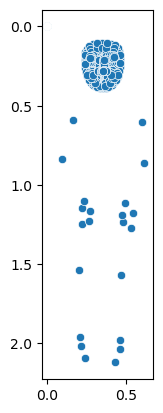

In [137]:
from IPython.display import clear_output
from IPython.display import display, Image, clear_output
from matplotlib.animation import FuncAnimation
from PIL import Image as PILImage

def plot_movement(video,  plot_parts = POSE+LH+RH+FACE, highlight=[]):
    min_x, min_y = np.min(video[:,:,0]), np.min(video[:,:,1])
    max_x, max_y = np.max(video[:,:,0]), np.max(video[:,:,1])

    fig, ax = plt.subplots()
    
    def update(frame):
        ax.clear()
        sns.scatterplot(x=video[frame][plot_parts, 0], y=video[frame][plot_parts, 1])
        if len(highlight) > 0:
            sns.scatterplot(x=video[frame][highlight, 0], y=video[frame][highlight, 1], color='red', s=100, marker='X')
        sns.scatterplot(x=[min_x,max_x], y=[min_y,max_y], color='white') # lock the size (not by GPT)

        ax.invert_yaxis()
        ax.set_aspect('equal')
        clear_output(wait=True)
        display(fig)

    anim = FuncAnimation(fig, update, frames=len(video), repeat=False)
    anim.save('landmarks_animation.gif', writer='pillow', fps=30)

shifted = shift_hands(id = '69241',video = landmarks['69241'],shift_rate = [[-5,5],[-5,5],[0,1]])
plot_movement(video= shifted[1])


## 1.2 Second augmentation type
Flipping along the X axis, we define the flipping axis as the center of the eyes altough it does not matter.

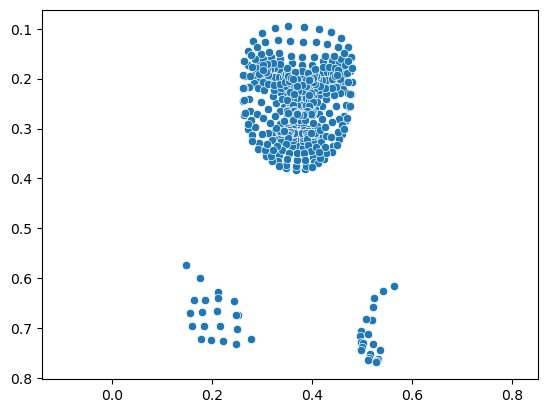

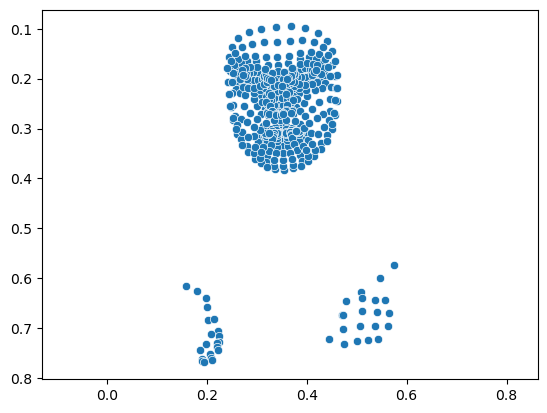

In [152]:
def flip_hands(id, video):
    v = video.copy()
    center = video[0,POSE_GROUPS['eyes'],0].mean()
    for frame in range(v.shape[0]):
        # Flip landmarks along the x-axis
        v[frame,:, 0] = 2 * center - v[frame,:, 0]

    new_id = id+'_flip'
    return new_id, v

mirrored = flip_hands(id = '69241',video = landmarks['69241'])
plot_landmarks(mirrored[1][19,:,:], plot_parts=FACE+LH+RH)
plot_landmarks(landmarks['69241'][19,:,:], plot_parts=FACE+LH+RH)

## 1.3 Third Augmentation - zooming
For now we skip the third augmentation type. We might come back to it after we try to train the model, if we think it might help

## 2 Save the augmented landmarks
As we are building a prototype we choose only a subset of the 2000 words, then increase the number of instances by applying the augmentations. We can even apply both augmentations on the data.


## 2.1 Choose the words
Let's choose words that can build sentences, if the training is good we eventually want to try to translate whole sentences.

In [156]:
import pyperclip
from collections import Counter
top500 = dict(Counter(data_info.word).most_common(500)).keys() # Words with many instances
pyperclip.copy('\n'.join(top500)) # copy to clipboard

The list of words was copied to clipboard and we asked ChatGPT the following:

*Here is a list of words, can you build 5 sentences from them, output both the sentence itself and the raw words as they appear in the list:*

**The results:**

1. Sentence: "The tall man can play basketball."<br>
Raw Words: tall man play basketball

2. Sentence: "The cold pizza tastes delicious."<br>
Raw Words: cold pizza taste delicious

3. Sentence: "The dark room is empty."<br>
Raw Words: dark room empty

4. Sentence: "The big dog can walk."<br>
Raw Words: big dog walk

5. Sentence: "The short woman has a beautiful daughter."<br>
Raw Words: short woman have beautiful daughter


**Another Promt:**

*Can you make them slightly longer? Same rules apply*

**The results:**

1. Sentence: "The tall man, wearing a red shirt, can play basketball very well in the neighborhood."<br>
Raw Words: tall man red shirt play basketball well neighborhood

2. Sentence: "The cold pizza, topped with extra cheese, tastes absolutely delicious on a lazy Sunday afternoon."<br>
Raw Words: cold pizza top extra cheese taste absolutely delicious lazy Sunday afternoon

3. Sentence: "The dark room, lit only by a small lamp, is completely empty and echoes with silence."<br>
Raw Words: dark room lit small lamp completely empty echo silence

4. Sentence: "The big dog, with a wagging tail, can walk happily in the beautiful park every morning."<br>
Raw Words: big dog wag tail walk happily beautiful park every morning

5. Sentence: "The short woman, wearing a colorful dress, has a beautiful daughter who excels in both academics and sports."<br>
Raw Words: short woman wear colorful dress have beautiful daughter excel academics sports

In [208]:
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'well', 
'neighborhood', 'cold', 'pizza', 'top', 'extra', 'cheese', 
'taste', 'absolutely', 'delicious', 'lazy', 'Sunday',
'afternoon', 'dark', 'room', 'lit', 'small', 'lamp', 'completely',
'empty', 'echo', 'silence', 'big', 'dog', 'wag', 'tail', 'walk',
'happily', 'beautiful', 'park', 'every', 'morning', 'short',
'woman', 'wear', 'colorful', 'dress', 'have', 'beautiful',
'daughter', 'excel', 'academics', 'sports']
Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

In [213]:
subset_data_info = data_info.loc[data_info.word.isin(subset_words),:]
for id, video in landmarks.items():
    shift_rate = np.array([])
    shifted_id, shifted_landmarks = shift_hands(id = id, video = video, shift_rate = shift_rate)
    mirrored_id, mirrored_landmarks = flip_hands(id = id,video = video)
    mirrored_shifted_id, mirrored_shifted_landmarks = flip_hands(id = shifted_id,video = shifted_landmarks)
    
    landmarks[shifted_id] = shifted_landmarks
    landmarks[mirrored_id] = mirrored_landmarks
    landmarks[mirrored_shifted_id] = mirrored_shifted_landmarks
    


(31,)

In [214]:
foo = {}
foo['id'] = np.array([1,2,3])
foo

{'id': array([1, 2, 3])}